In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
import pymysql
import pyodbc

In [4]:
# Load .env variables
from dotenv import load_dotenv
print(load_dotenv())

True


In [5]:
# Create MySQL connection (AWS RDS)
mysql_engine = create_engine(
    f"mysql+pymysql://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASS')}@{os.getenv('MYSQL_HOST')}/{os.getenv('MYSQL_DB')}"
)

# Create MSSQL connection
mssql_engine = create_engine(
    f"mssql+pyodbc://{os.getenv('MSSQL_USER')}:{os.getenv('MSSQL_PASS')}@{os.getenv('MSSQL_HOST')}/{os.getenv('MSSQL_DB')}?driver={os.getenv('MSSQL_DRIVER')}&Encrypt=yes&TrustServerCertificate=no"
)

In [140]:
# Step 1: Read from AWS MySQL
df = pd.read_sql("SELECT * FROM gurgaon_properties_cleaned_v3", con=mysql_engine)
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,house,independent,sector 4,0.67,8557.0,783.0,Plot area 87(72.74 sq.m.),3,2,1,1,South,Moderately Old,NaN,783.0,NaN,0,0,0,1,1,0,19
1,flat,zara aavaas,sector 104,0.65,8519.0,763.0,Carpet area: 763 (70.89 sq.m.),3,2,2,7,NA,New Property,NaN,NaN,763.0,0,0,0,0,0,0,65
2,house,DLF New Town Heights 24.0 ?,sector 86,2.47,7718.0,3200.0,Plot area 3200(297.29 sq.m.)Built Up area: 280...,4,4,3+,0,West,Moderately Old,NaN,2800.0,2200.0,0,1,0,1,0,2,130
3,flat,shree vardhman victoria,sector 70,1.65,8461.0,1950.0,Super Built up area 1950(181.16 sq.m.)Carpet a...,3,4,3,5,South-East,Relatively New,1950.0,NaN,1161.0,0,1,0,0,1,2,49
4,flat,central park resort belgravia residences,sector 48,6.25,24300.0,2572.0,Carpet area: 2880 (267.56 sq.m.),3,5,3+,5,South-East,Moderately Old,NaN,NaN,2880.0,0,1,0,0,0,2,49


In [141]:
df.shape

(3674, 23)

In [142]:
# To show all rows and columns in the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



In [143]:
df.columns

Index(['property_type', 'society', 'sector', 'price', 'price_per_sqft', 'area',
       'areaWithType', 'bedRoom', 'bathroom', 'balcony', 'floorNum', 'facing',
       'agePossession', 'super_built_up_area', 'built_up_area', 'carpet_area',
       'study room', 'servant room', 'store room', 'pooja room', 'others',
       'furnishing_type', 'luxury_score'],
      dtype='object')

<Axes: xlabel='price', ylabel='Count'>

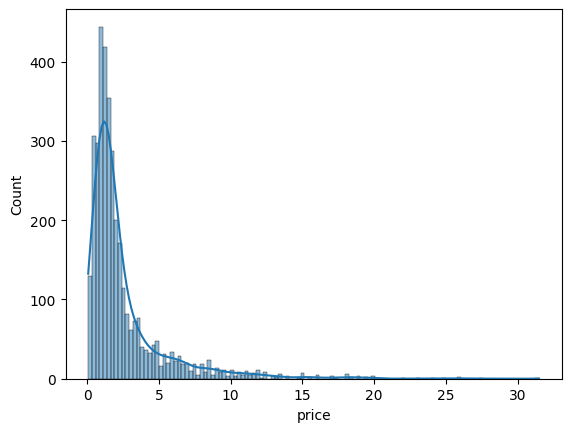

In [144]:
# outliers on the basis of price column
sns.histplot(df['price'], kde=True)

<Axes: xlabel='price'>

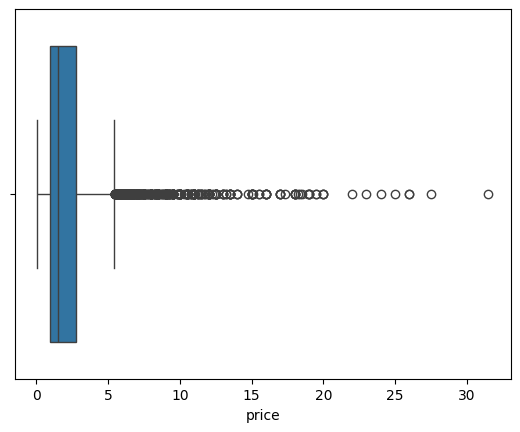

In [145]:
sns.boxplot(x=df['price'])

In [146]:
# Calculate the IQR for the 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

# Displaying the number of outliers and some statistics
num_outliers = outliers.shape[0]
outliers_price_stats = outliers['price'].describe()

num_outliers, outliers_price_stats

(425,
 count    425.000000
 mean       9.235624
 std        4.065259
 min        5.460000
 25%        6.460000
 50%        8.000000
 75%       10.750000
 max       31.500000
 Name: price, dtype: float64)

In [147]:
outliers.sort_values('price',ascending=False).head(20)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2341,house,Arjun Marg/ Sector- 26 Phase- 1/ Golf Course Road,sector 26,31.50,35000.0,9000.0,Plot area 1000(836.13 sq.m.),7,9,3+,3,North-East,Moderately Old,NaN,9000.0,NaN,1,1,1,1,0,1,74
1600,house,independent,sector 43,27.50,24366.0,11286.0,Plot area 1254(1048.5 sq.m.),6,7,3+,3,North-East,Relatively New,NaN,11286.0,NaN,1,1,0,1,1,2,42
932,house,DLF City Plots,sector 26,26.00,57206.0,4545.0,Plot area 505(422.24 sq.m.),6,7,3+,2,North-East,New Property,NaN,4545.0,NaN,1,1,0,1,1,2,138
2275,house,independent,sector 26,26.00,82540.0,3150.0,Plot area 402(336.12 sq.m.)Built Up area: 400 ...,16,16,3+,4,North-West,New Property,NaN,400.0,350.0,1,1,1,1,0,2,72
3441,house,Suncity Township4.1 ?,sector 54,25.00,31111.0,8036.0,Plot area 1000(836.13 sq.m.),4,4,3+,2,North,Moderately Old,NaN,1000.0,NaN,1,1,1,1,0,0,0
2861,house,Emaar The Palm Springs,sector 54,24.00,600000.0,400.0,Plot area 400(37.16 sq.m.),5,5,2,1,North-East,Old Property,NaN,400.0,NaN,1,1,0,1,0,2,122
1433,house,independent,sector 26,23.00,25556.0,9000.0,Plot area 1000(836.13 sq.m.),4,4,3+,2,South-West,Relatively New,NaN,9000.0,NaN,1,1,1,1,0,2,145
3027,house,Vipul Tatvam Villa,sector 48,22.00,26667.0,8250.0,Plot area 1000(836.13 sq.m.),5,6,3,3,NA,Moderately Old,NaN,1000.0,NaN,0,1,0,0,0,0,54
1752,house,DLF City Plots,sector 26,20.00,44265.0,4518.0,Plot area 502(419.74 sq.m.),16,20,3+,4,North-East,New Property,NaN,4518.0,NaN,1,1,1,1,0,2,153
2138,house,Luxury DLF City Floors,sector 26,20.00,48889.0,4091.0,Plot area 500(418.06 sq.m.),16,16,3+,4,NA,New Property,NaN,500.0,NaN,0,1,0,0,0,2,31


 on the basis of price col we can say that there are some genuine outliers but there are some data erros as well

### Price_per_sqft


<Axes: xlabel='price_per_sqft', ylabel='Count'>

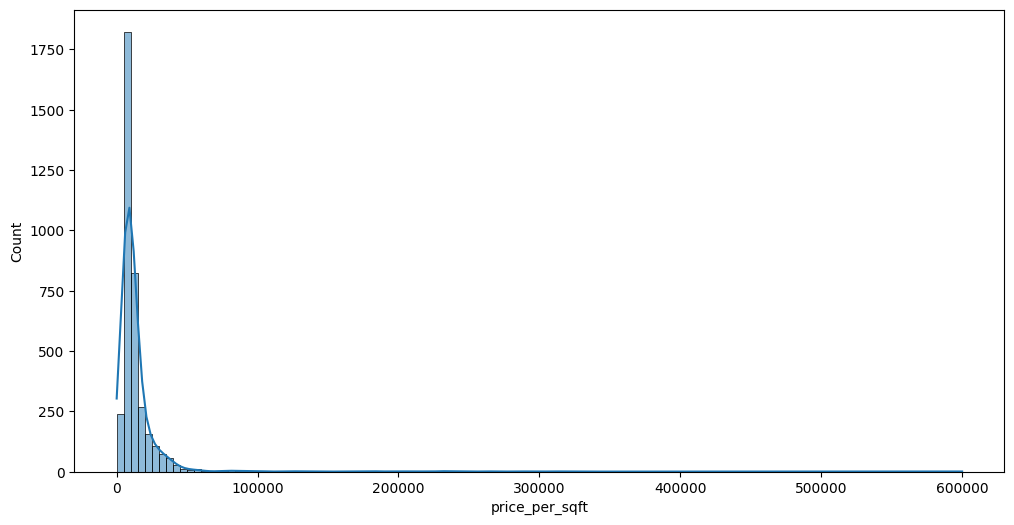

In [148]:
plt.figure(figsize=(12, 6))  # Width = 12, Height = 6
sns.histplot(df['price_per_sqft'], kde=True)

<Axes: xlabel='price_per_sqft'>

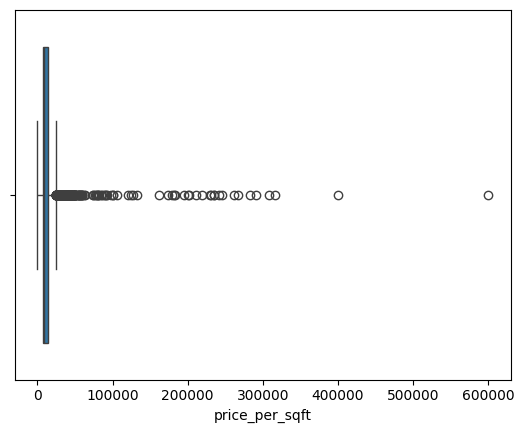

In [149]:
sns.boxplot(x=df['price_per_sqft'])

In [150]:
# Calculate the IQR for the 'price' column
Q1 = df['price_per_sqft'].quantile(0.25)
Q3 = df['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_sqft = df[(df['price_per_sqft'] < lower_bound) | (df['price_per_sqft'] > upper_bound)]

# Displaying the number of outliers and some statistics
num_outliers = outliers_sqft.shape[0]
outliers_sqft_stats = outliers_sqft['price_per_sqft'].describe()

num_outliers, outliers_sqft_stats

(354,
 count       354.000000
 mean      52592.612994
 std       61150.458507
 min       24489.000000
 25%       28208.250000
 50%       33368.500000
 75%       41982.250000
 max      600000.000000
 Name: price_per_sqft, dtype: float64)

In [151]:
# correcting the area values less than 1000 to sqrft

outliers_sqft['area'] = outliers_sqft['area'].apply(lambda x:x*9 if x<1000 else x)

C:\Users\wasi\AppData\Local\Temp\ipykernel_4276\2650260792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_sqft['area'] = outliers_sqft['area'].apply(lambda x:x*9 if x<1000 else x)


In [152]:
# recalculating price_per_sqft after correcting area values
outliers_sqft['price_per_sqft'] = round((outliers_sqft['price']*10000000)/outliers_sqft['area'])

C:\Users\wasi\AppData\Local\Temp\ipykernel_4276\1615325923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_sqft['price_per_sqft'] = round((outliers_sqft['price']*10000000)/outliers_sqft['area'])


In [153]:
outliers_sqft['price_per_sqft'].describe()

count      354.000000
mean     29357.906780
std      12403.077309
min       2723.000000
25%      25562.000000
50%      29870.500000
75%      35549.500000
max      82540.000000
Name: price_per_sqft, dtype: float64

In [154]:
# update the original DataFrame with the corrected outliers
df.update(outliers_sqft)

<Axes: xlabel='price_per_sqft', ylabel='Count'>

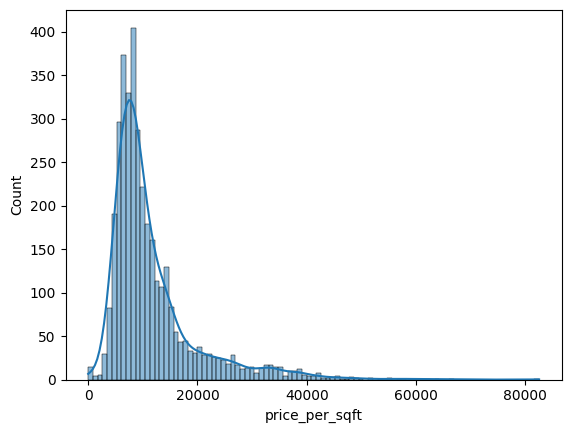

In [155]:
sns.histplot(df['price_per_sqft'], kde = True)

<Axes: xlabel='price_per_sqft'>

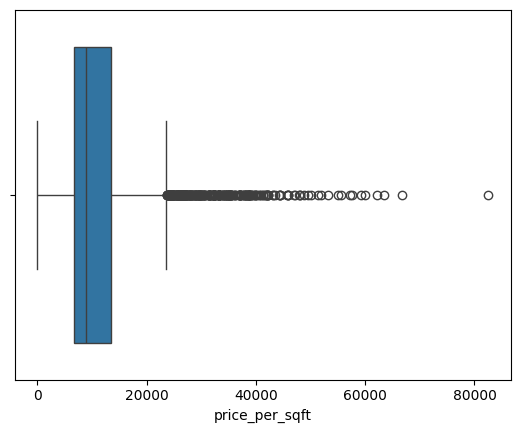

In [156]:
sns.boxplot(x=df['price_per_sqft'])

In [157]:
#  outlier rows
df[df['price_per_sqft']>50000].shape

(13, 23)

In [158]:
# removing outliers base on price_per_sqft
df = df[df['price_per_sqft'] <= 50000]

In [159]:
df.shape

(3645, 23)

<Axes: xlabel='price_per_sqft'>

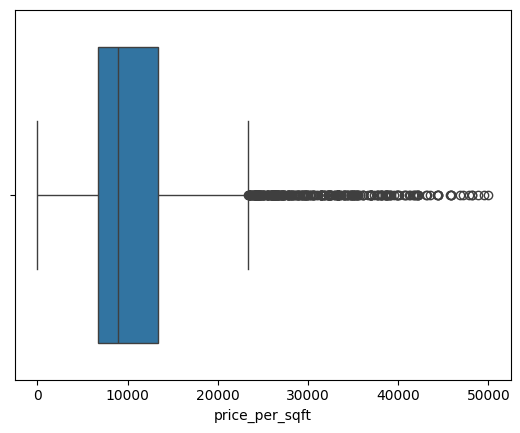

In [160]:
sns.boxplot(x=df['price_per_sqft'])

### Area

<Axes: xlabel='area', ylabel='Count'>

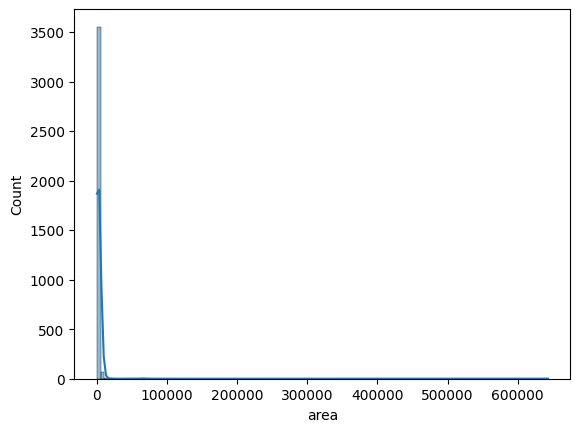

In [161]:
sns.histplot(df['area'],kde=True)

<Axes: xlabel='area'>

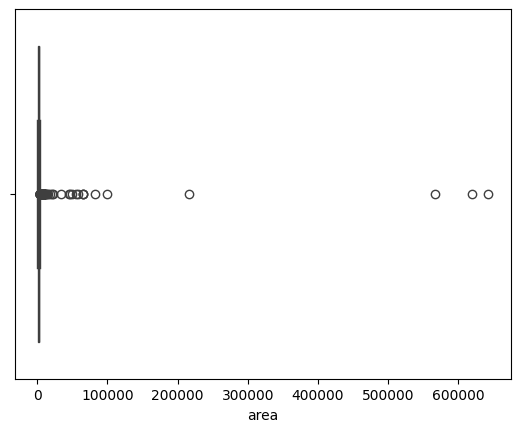

In [162]:
sns.boxplot(x=df['area'])

In [163]:
df['area'].describe()

count      3645.000000
mean       2708.651303
std       18170.481693
min         145.000000
25%        1261.000000
50%        1750.000000
75%        2350.000000
max      642857.000000
Name: area, dtype: float64

In [164]:
df[df['area'] > 100000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
187,flat,signature global solera 2,sector 107,0.51,9.0,566667.0,Carpet area: 514396 (47788.95 sq.m.),2,2,1,3,North,New Property,NaN,NaN,514396.0,0,0,0,0,0,0,44
456,flat,ramsons kshitij,sector 95,0.31,5.0,620000.0,Carpet area: 607936 (56479.1 sq.m.),2,2,1,1,North-East,Relatively New,NaN,NaN,607936.0,1,0,0,0,1,0,65
2055,house,independent,sector 50,5.00,232.0,215517.0,Plot area 2(1011.71 sq.m.),6,5,3+,2,NA,New Property,NaN,2.0,NaN,1,1,0,1,1,2,0
3060,flat,signature the roselia,sector 95,0.45,7.0,642857.0,Carpet area: 569243 (52884.41 sq.m.),2,2,2,2,South-West,New Property,NaN,NaN,569243.0,0,0,0,0,0,0,76


In [165]:
# removing outliers based on area
df = df[df['area'] < 100000]

<Axes: xlabel='area', ylabel='Count'>

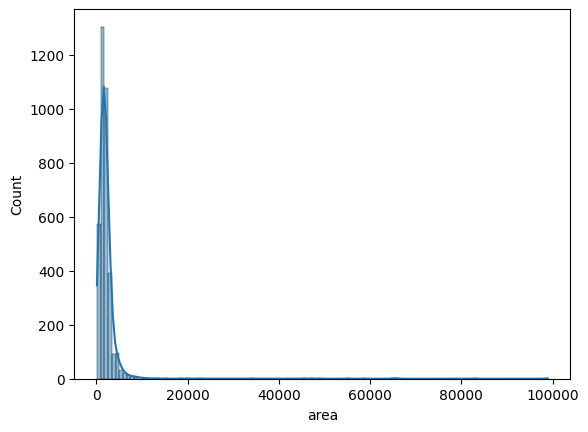

In [166]:
sns.histplot(df['area'], kde=True)

<Axes: xlabel='area'>

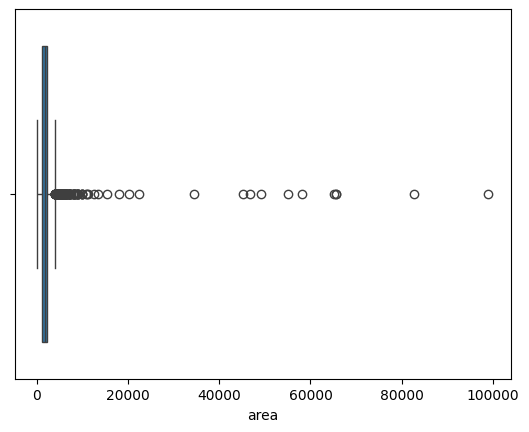

In [167]:
sns.boxplot(x=df['area'])

In [168]:
df[df['area'] > 10000].sort_values('area',ascending=False)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
49,house,independent,sector 26,18.40,1859.0,98978.0,Plot area 502(419.74 sq.m.)Carpet area: 11000 ...,6,8,3+,4,South,Relatively New,NaN,NaN,11000.00,0,1,1,1,0,2,60
2721,house,Ganpati Heights Apartment,sector 13,1.25,151.0,82781.0,Plot area 115(7692.86 sq.m.),10,6,2,3,South-East,Old Property,NaN,115.0,NaN,0,0,0,0,1,0,7
3641,flat,rof ananda,sector 95,0.38,58.0,65517.0,Carpet area: 64529 (5994.94 sq.m.),2,2,2,10,East,New Property,NaN,NaN,64529.00,1,0,0,0,0,0,15
3490,flat,rof ananda,sector 95,0.38,58.0,65517.0,Carpet area: 64412 (5984.07 sq.m.),3,2,1,12,North,Relatively New,NaN,NaN,64412.00,0,0,0,0,0,0,51
453,house,DLF City Plot Phase 4,sector 28,13.00,1992.0,65261.0,Carpet area: 7250 (6061.92 sq.m.),10,10,3+,1,NA,Undefined,NaN,NaN,7250.00,0,0,0,0,0,0,0
2178,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,0,NA,Under Construction,NaN,NaN,58141.00,0,0,0,0,0,0,15
1329,flat,rof ananda,sector 95,0.33,60.0,55000.0,Carpet area: 54917 (5101.96 sq.m.),2,2,1,13,South-West,Relatively New,NaN,NaN,54917.00,0,0,0,0,0,0,37
881,flat,signature the serenas,sohna road,0.28,57.0,49123.0,Carpet area: 48811 (4534.69 sq.m.),1,1,2,1,North-West,Relatively New,NaN,NaN,48811.00,1,0,0,0,0,0,37
3363,house,independent,sector 25,7.30,1560.0,46795.0,Plot area 215(179.77 sq.m.)Built Up area: 5800...,9,9,2,3,North-West,Relatively New,NaN,5800.0,5200.00,0,1,1,0,0,2,109
1171,flat,ramsons kshitij,sector 95,0.24,53.0,45283.0,Carpet area: 45966 (4270.38 sq.m.),2,2,1,10,North-West,Relatively New,NaN,NaN,45966.00,0,0,0,0,1,0,33


In [169]:
df.drop(index=[49, 3641, 3490, 2178, 1329, 881, 1171, 2309, 1060], inplace=True)

In [170]:
df[df['area'] > 10000].sort_values('area',ascending=False)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2721,house,Ganpati Heights Apartment,sector 13,1.25,151.0,82781.0,Plot area 115(7692.86 sq.m.),10,6,2,3,South-East,Old Property,NaN,115.0,NaN,0,0,0,0,1,0,7
453,house,DLF City Plot Phase 4,sector 28,13.00,1992.0,65261.0,Carpet area: 7250 (6061.92 sq.m.),10,10,3+,1,NA,Undefined,NaN,NaN,7250.00,0,0,0,0,0,0,0
3363,house,independent,sector 25,7.30,1560.0,46795.0,Plot area 215(179.77 sq.m.)Built Up area: 5800...,9,9,2,3,North-West,Relatively New,NaN,5800.0,5200.00,0,1,1,0,0,2,109
2066,house,independent,sector 57,6.25,2778.0,22498.0,Plot area 3100(2591.99 sq.m.)Built Up area: 26...,9,9,3+,3,North-East,New Property,NaN,2660.0,2500.00,0,1,0,0,0,2,61
2606,house,independent,sector 43,5.50,2716.0,20250.0,Plot area 215(179.77 sq.m.)Built Up area: 2850...,8,7,3+,3,East,Moderately Old,NaN,2850.0,2250.00,1,1,0,1,1,2,123
2711,flat,godrej air,sector 85,2.50,1379.0,18129.0,Carpet area: 18122 (1683.59 sq.m.),4,5,3+,16,North-East,New Property,NaN,NaN,18122.00,1,0,0,1,1,2,44
3298,house,Unitech Aspen Greens,sector 50,6.95,4490.0,15479.0,Plot area 240(200.67 sq.m.)Built Up area: 2160...,3,3,1,2,North-East,Moderately Old,NaN,2160.0,1720.00,0,1,0,0,0,0,160
1578,flat,godrej icon,sector 88a,1.75,1384.0,12645.0,Carpet area: 1175.11,3,3,3+,6,NA,New Property,NaN,NaN,1175.11,0,0,0,0,0,0,55
1600,house,independent,sector 43,27.50,24366.0,11286.0,Plot area 1254(1048.5 sq.m.),6,7,3+,3,North-East,Relatively New,NaN,11286.0,NaN,1,1,0,1,1,2,42
1906,flat,m3m golfestate,sector 65,13.20,12000.0,11000.0,Carpet area: 11000 (1021.93 sq.m.),4,4,3,13,North,Moderately Old,NaN,NaN,11000.00,0,1,0,0,0,0,60


In [181]:
# correcting the area values for specific outliers
df.loc[2721,'area'] = 115*9
df.loc[453,'area'] = 7250
df.loc[3363,'area'] = 5800
df.loc[3363,'area'] = 2660
df.loc[2066,'area'] = 2090
df.loc[2606,'area'] = 2850
df.loc[2711,'area'] = 1812
df.loc[3298,'area'] = 2160
df.loc[1578,'area'] = 1175

<Axes: xlabel='area', ylabel='Count'>

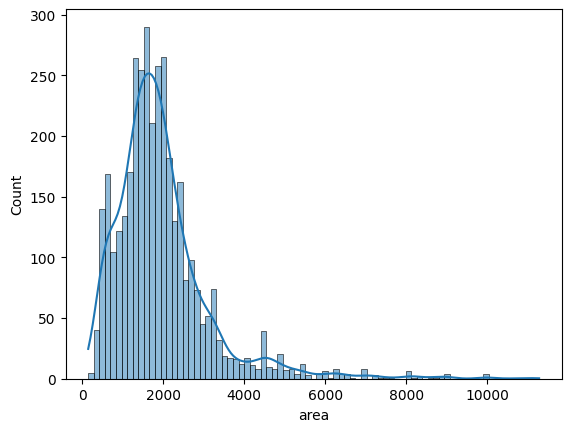

In [182]:
sns.histplot(df['area'], kde =  True)

<Axes: xlabel='area'>

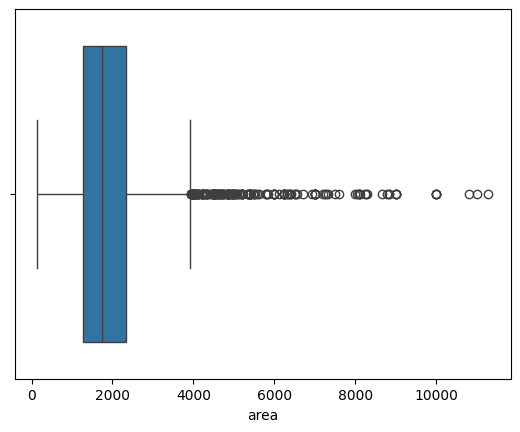

In [183]:
sns.boxplot(x=df['area'])

In [184]:
df['area'].describe()

count     3632.000000
mean      1949.235407
std       1214.269630
min        145.000000
25%       1260.000000
50%       1746.500000
75%       2325.000000
max      11286.000000
Name: area, dtype: float64

### Bedroom

<Axes: xlabel='bedRoom', ylabel='Count'>

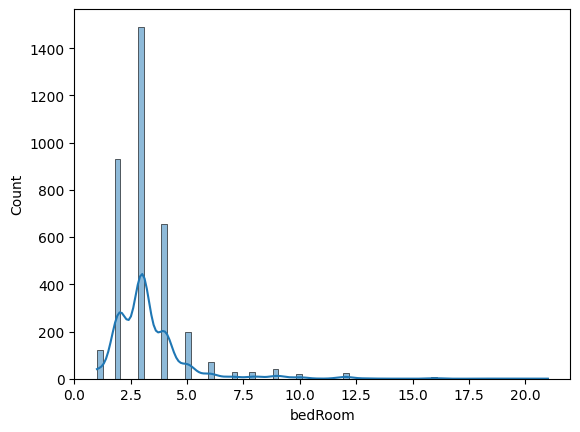

In [188]:
sns.histplot(df['bedRoom'], kde=True)

<Axes: xlabel='bedRoom'>

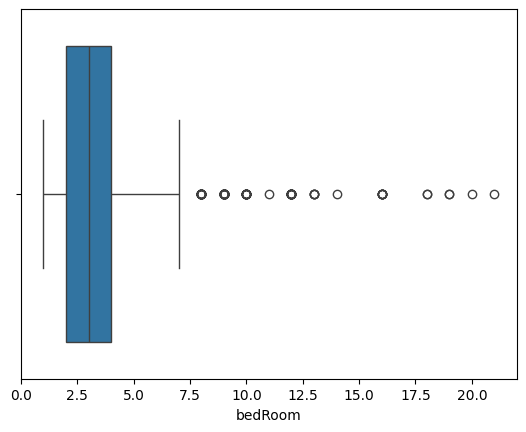

In [189]:
sns.boxplot(x=df['bedRoom'])

In [190]:
df['bedRoom'].describe()

count    3632.000000
mean        3.333700
std         1.830278
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        21.000000
Name: bedRoom, dtype: float64

In [191]:
df[df['bedRoom'] > 10].sort_values('bedRoom',ascending=False)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1776,house,independent,sector 54,5.00,43066.0,1161.0,Plot area 129(107.86 sq.m.),21,21,3+,5,North,Relatively New,NaN,1161.0,NaN,0,1,0,0,0,1,49
2907,house,independent,sector 43,4.50,39062.0,1152.0,Plot area 128(107.02 sq.m.),20,20,3+,4,East,Relatively New,NaN,1152.0,NaN,0,1,0,0,0,1,22
672,house,independent,sector 17a,3.93,24214.0,1623.0,Plot area 1623(150.78 sq.m.)Built Up area: 162...,19,17,3,4,North-West,Relatively New,NaN,1622.0,NaN,1,1,1,1,0,0,74
1102,house,independent,sector 17a,3.87,5160.0,7500.0,Plot area 1623(150.78 sq.m.)Built Up area: 750...,19,17,3+,5,North-West,Relatively New,NaN,7500.0,NaN,1,0,1,0,0,0,68
832,house,independent,sector 54,5.50,38194.0,1440.0,Plot area 160(133.78 sq.m.),18,18,3+,4,South-West,Relatively New,NaN,1440.0,NaN,0,1,0,0,0,1,70
1594,house,private house,sector 55,7.05,46906.0,1503.0,Plot area 167(139.63 sq.m.),18,18,3+,4,North-East,Relatively New,NaN,1503.0,NaN,0,0,0,0,1,1,57
1711,house,independent,sector 43,13.50,50000.0,2700.0,Plot area 300(250.84 sq.m.),16,16,3+,4,North-West,Relatively New,NaN,2700.0,NaN,1,1,0,1,1,0,41
2437,house,independent,sector 56,12.39,45889.0,2700.0,Plot area 300(250.84 sq.m.),16,18,3+,4,North-East,New Property,NaN,2700.0,NaN,0,1,0,1,0,2,49
1894,house,independent,sector 40,12.00,38986.0,3078.0,Plot area 342(285.96 sq.m.),16,16,3+,4,NA,New Property,NaN,3078.0,NaN,1,1,1,1,0,2,0
1752,house,DLF City Plots,sector 26,20.00,44267.0,4518.0,Plot area 502(419.74 sq.m.),16,20,3+,4,North-East,New Property,NaN,4518.0,NaN,1,1,1,1,0,2,153


In [192]:
# removing outliers based on bedRoom
df = df[df['bedRoom'] <= 10]

In [193]:
df.shape

(3587, 23)

<Axes: xlabel='bedRoom', ylabel='Count'>

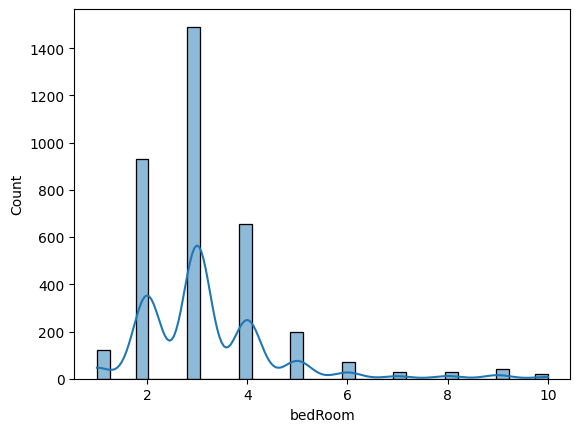

In [195]:
sns.histplot(df['bedRoom'], kde=True)

<Axes: xlabel='bedRoom'>

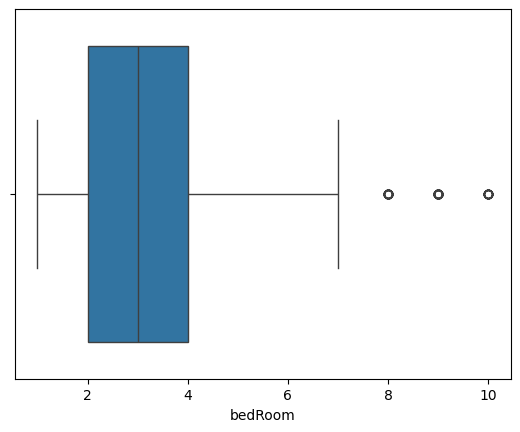

In [196]:
sns.boxplot(x=df['bedRoom'])

In [197]:
df['bedRoom'].describe()


count    3587.000000
mean        3.203791
std         1.394158
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: bedRoom, dtype: float64

### Bathroom

<Axes: xlabel='bathroom', ylabel='Count'>

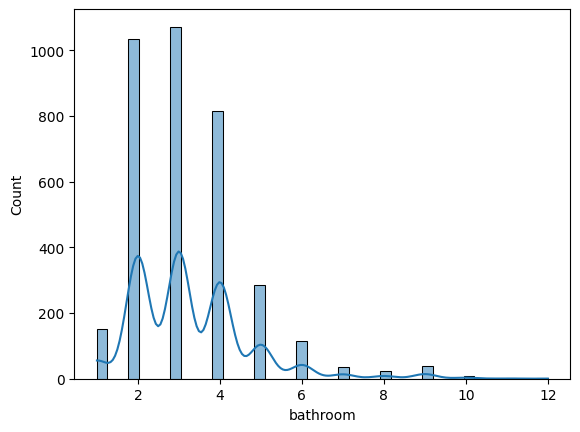

In [199]:
sns.histplot(df['bathroom'], kde=True)

<Axes: xlabel='bathroom'>

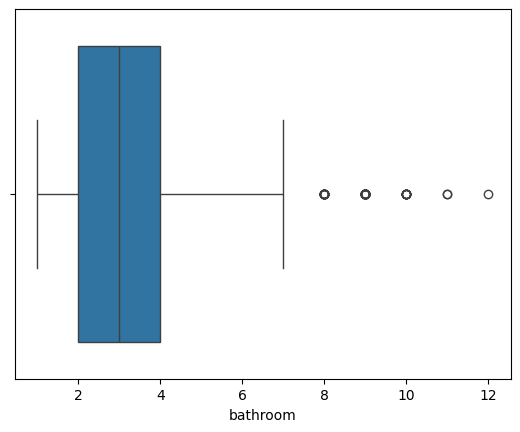

In [200]:
sns.boxplot(x=df['bathroom'])

In [ ]:
# not removing because its matching with the number of bedRoom counts
df[df['bathroom'] > 10].sort_values('bathroom',ascending=False)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1002,house,Adani Brahma Samsara4.2 ?,sector 60,18.02,28200.0,6390.0,Built Up area: 6390 (593.65 sq.m.),9,12,3+,3,North-East,Relatively New,NaN,6390.0,NaN,0,1,0,0,0,2,146
268,house,independent,sector 39,7.00,10000.0,7000.0,Plot area 350(32.52 sq.m.)Built Up area: 7000 ...,10,11,3+,4,South-East,Relatively New,NaN,7000.0,NaN,0,0,0,1,0,2,38
2148,house,independent,sector 24,11.00,28902.0,3806.0,Plot area 3806.45(353.63 sq.m.)Built Up area: ...,8,11,3+,3,East,Old Property,NaN,5000.0,NaN,1,1,0,1,1,2,39


In [202]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,house,independent,sector 4,0.67,8557.0,783.0,Plot area 87(72.74 sq.m.),3,2,1,1,South,Moderately Old,NaN,783.0,NaN,0,0,0,1,1,0,19
1,flat,zara aavaas,sector 104,0.65,8519.0,763.0,Carpet area: 763 (70.89 sq.m.),3,2,2,7,NA,New Property,NaN,NaN,763.0,0,0,0,0,0,0,65
2,house,DLF New Town Heights 24.0 ?,sector 86,2.47,7718.0,3200.0,Plot area 3200(297.29 sq.m.)Built Up area: 280...,4,4,3+,0,West,Moderately Old,NaN,2800.0,2200.0,0,1,0,1,0,2,130
3,flat,shree vardhman victoria,sector 70,1.65,8461.0,1950.0,Super Built up area 1950(181.16 sq.m.)Carpet a...,3,4,3,5,South-East,Relatively New,1950.0,NaN,1161.0,0,1,0,0,1,2,49
4,flat,central park resort belgravia residences,sector 48,6.25,24300.0,2572.0,Carpet area: 2880 (267.56 sq.m.),3,5,3+,5,South-East,Moderately Old,NaN,NaN,2880.0,0,1,0,0,0,2,49


### super built up area

<Axes: xlabel='super_built_up_area', ylabel='Count'>

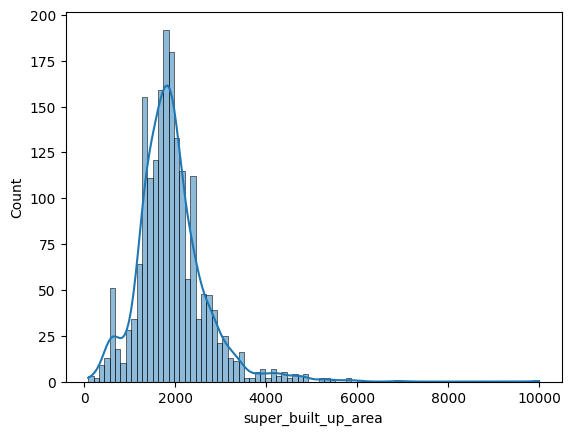

In [204]:
sns.histplot(df['super_built_up_area'], kde=True)

<Axes: xlabel='super_built_up_area'>

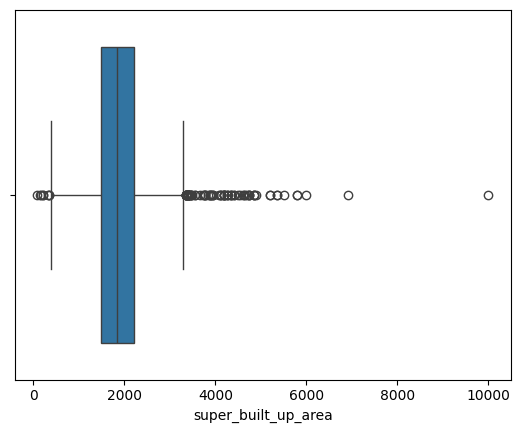

In [205]:
sns.boxplot(x=df['super_built_up_area'])

In [206]:
df['super_built_up_area'].describe()

count     1876.000000
mean      1924.780144
std        764.225294
min         89.000000
25%       1478.750000
50%       1828.000000
75%       2215.000000
max      10000.000000
Name: super_built_up_area, dtype: float64

In [207]:
df[df['super_built_up_area'] > 6000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2857,flat,bestech park view grand spa,sector 81,4.7,6786.0,6926.0,Super Built up area 6926(643.45 sq.m.),4,4,3+,19,North,Relatively New,6926.0,NaN,NaN,0,1,0,0,0,2,140
3192,flat,krrish provence estate,gwal pahari,7.5,7500.0,10000.0,Super Built up area 10000(929.03 sq.m.),5,6,3+,23,North-East,Relatively New,10000.0,NaN,NaN,0,1,0,1,1,0,49


### built up area

<Axes: xlabel='built_up_area', ylabel='Count'>

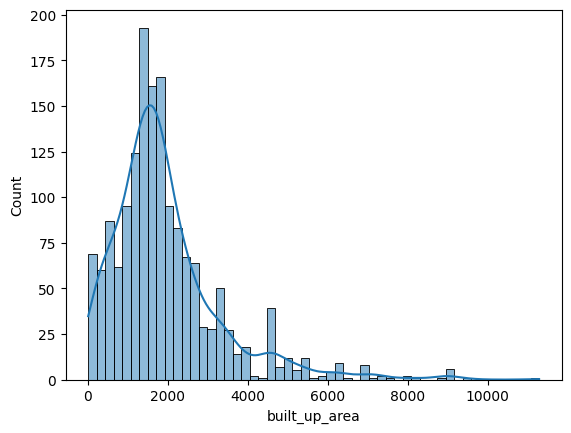

In [208]:
sns.histplot(df['built_up_area'], kde=True)

<Axes: xlabel='built_up_area'>

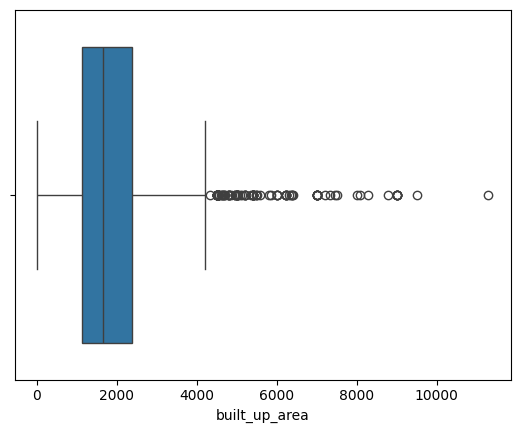

In [209]:
sns.boxplot(x=df['built_up_area'])

In [210]:
df[df['built_up_area'] > 10000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1600,house,independent,sector 43,27.5,24366.0,11286.0,Plot area 1254(1048.5 sq.m.),6,7,3+,3,North-East,Relatively New,NaN,11286.0,NaN,1,1,0,1,1,2,42


### carpet area

<Axes: xlabel='carpet_area', ylabel='Count'>

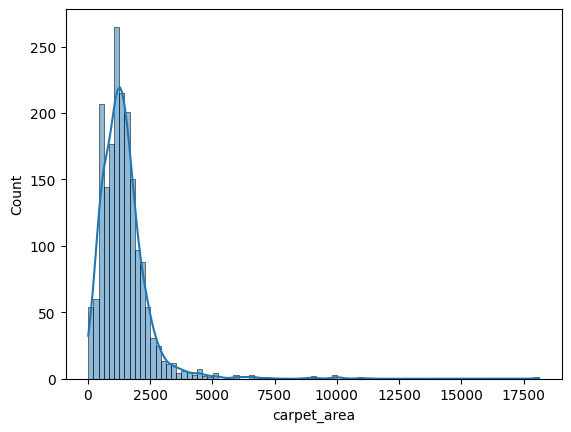

In [211]:
sns.histplot(df['carpet_area'], kde=True)

<Axes: xlabel='carpet_area'>

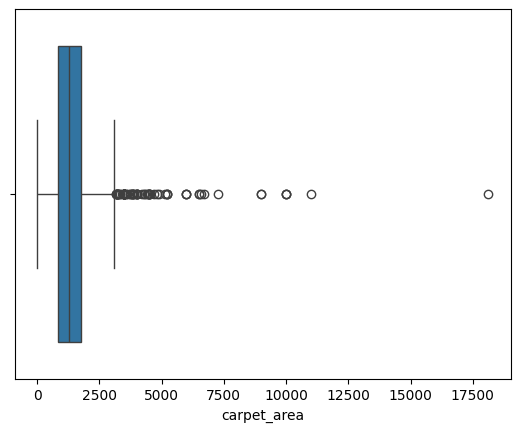

In [212]:
sns.boxplot(x=df['carpet_area'])

In [213]:
df[df['carpet_area'] > 10000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1906,flat,m3m golfestate,sector 65,13.2,12000.0,11000.0,Carpet area: 11000 (1021.93 sq.m.),4,4,3,13,North,Moderately Old,NaN,NaN,11000.0,0,1,0,0,0,0,60
2711,flat,godrej air,sector 85,2.5,1379.0,1812.0,Carpet area: 18122 (1683.59 sq.m.),4,5,3+,16,North-East,New Property,NaN,NaN,18122.0,1,0,0,1,1,2,44


In [214]:
df.loc[2711,'carpet_area'] = 1812

In [215]:
df[df['carpet_area'] > 10000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1906,flat,m3m golfestate,sector 65,13.2,12000.0,11000.0,Carpet area: 11000 (1021.93 sq.m.),4,4,3,13,North,Moderately Old,NaN,NaN,11000.0,0,1,0,0,0,0,60


In [216]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,house,independent,sector 4,0.67,8557.0,783.0,Plot area 87(72.74 sq.m.),3,2,1,1,South,Moderately Old,NaN,783.0,NaN,0,0,0,1,1,0,19
1,flat,zara aavaas,sector 104,0.65,8519.0,763.0,Carpet area: 763 (70.89 sq.m.),3,2,2,7,NA,New Property,NaN,NaN,763.0,0,0,0,0,0,0,65
2,house,DLF New Town Heights 24.0 ?,sector 86,2.47,7718.0,3200.0,Plot area 3200(297.29 sq.m.)Built Up area: 280...,4,4,3+,0,West,Moderately Old,NaN,2800.0,2200.0,0,1,0,1,0,2,130
3,flat,shree vardhman victoria,sector 70,1.65,8461.0,1950.0,Super Built up area 1950(181.16 sq.m.)Carpet a...,3,4,3,5,South-East,Relatively New,1950.0,NaN,1161.0,0,1,0,0,1,2,49
4,flat,central park resort belgravia residences,sector 48,6.25,24300.0,2572.0,Carpet area: 2880 (267.56 sq.m.),3,5,3+,5,South-East,Moderately Old,NaN,NaN,2880.0,0,1,0,0,0,2,49


### luxury_score

<Axes: xlabel='luxury_score', ylabel='Count'>

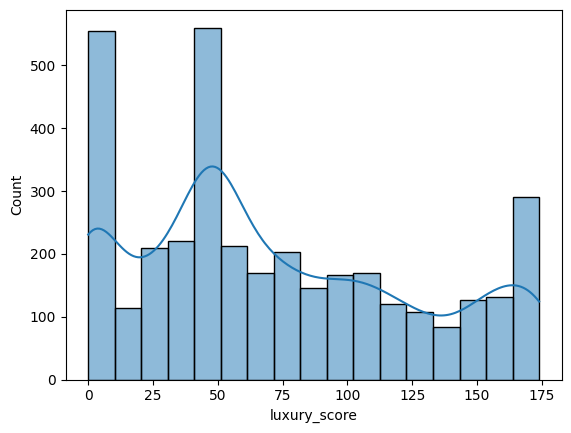

In [217]:
sns.histplot(df['luxury_score'], kde=True)

<Axes: xlabel='luxury_score'>

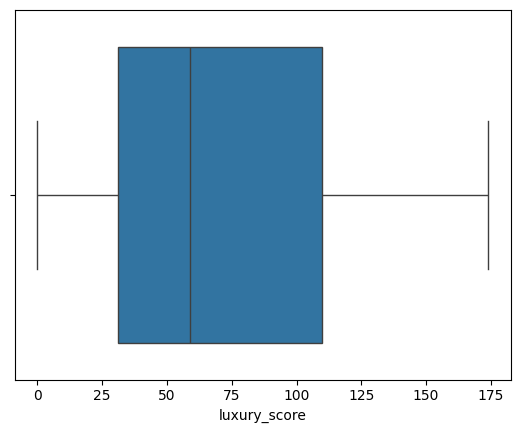

In [219]:
sns.boxplot(x = df['luxury_score'])

In [220]:
df.shape

(3587, 23)

In [221]:
# as we have done cone changes in area and price_per_sqft, we need to recalculate price_per_sqft
df['price_per_sqft'] = round((df['price']*10000000)/df['area'])

<Axes: xlabel='price_per_sqft', ylabel='Count'>

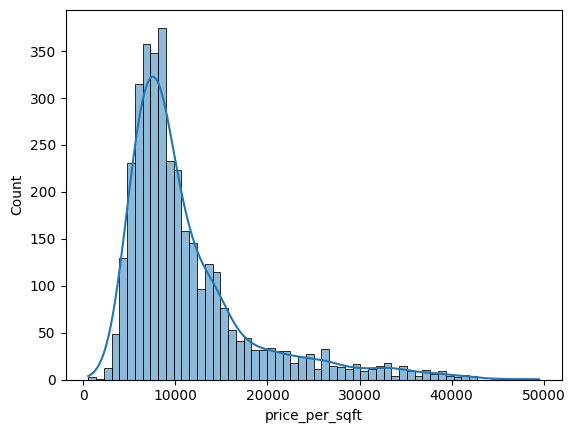

In [223]:
sns.histplot(df['price_per_sqft'], kde=True)

<Axes: xlabel='price_per_sqft'>

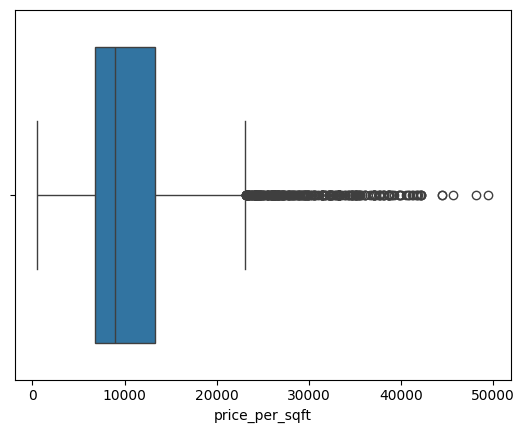

In [225]:
sns.boxplot(x =df['price_per_sqft'])

In [226]:
df[df['price_per_sqft'] > 42000]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
385,house,independent,sector 26,20.0,44444.0,4500.0,Plot area 500(418.06 sq.m.),5,7,3+,3,West,Relatively New,NaN,4500.0,NaN,0,1,0,1,0,1,97
578,house,independent,sector 25,13.0,45710.0,2844.0,Plot area 316(264.22 sq.m.),6,8,3+,0,NA,Relatively New,NaN,2844.0,NaN,1,1,1,1,0,1,0
606,house,independent,sector 28,12.0,42194.0,2844.0,Plot area 316(264.22 sq.m.),4,5,3+,4,East,Relatively New,NaN,2844.0,NaN,0,1,1,1,0,2,60
1391,house,independent,sector 55,5.0,44444.0,1125.0,Plot area 125(104.52 sq.m.)Built Up area: 115 ...,9,9,3+,5,East,New Property,NaN,115.0,100.0,0,0,0,0,1,2,44
1613,house,independent,sector 105,9.9,49500.0,2000.0,Built Up area: 2000 (185.81 sq.m.)Carpet area:...,2,2,2,3,North,Undefined,NaN,2000.0,1800.0,0,0,0,0,0,0,0
2806,house,independent,sector 26,19.0,42222.0,4500.0,Plot area 500(418.06 sq.m.),6,8,3+,3,East,Moderately Old,NaN,4500.0,NaN,1,1,1,1,0,2,103
3348,house,independent,sector 43,9.5,42222.0,2250.0,Plot area 302(252.51 sq.m.)Built Up area: 300 ...,5,5,3+,2,North-East,Relatively New,NaN,300.0,250.0,0,1,0,1,0,2,88
3622,house,DLF City Plots,sector 26,19.0,42054.0,4518.0,Plot area 502(419.74 sq.m.),6,6,3,2,East,Relatively New,NaN,4518.0,NaN,1,1,0,0,0,2,121
3642,house,Sushant Lok 1 Builder Floors,sector 43,13.0,48148.0,2700.0,Plot area 300(250.84 sq.m.),3,3,3+,4,North,New Property,NaN,2700.0,NaN,0,0,0,1,0,2,7


In [227]:
# Filter out properties where price per square foot is less than or equal to 20,000,
# then calculate the 2nd percentile of area per bedroom to identify extremely small room sizes (potential outliers)
x = df[df['price_per_sqft'] <= 20000]
(x['area'] / x['bedRoom']).quantile(0.02) # # 2nd percentile of area per bedroom means that 2% of the properties have an area per bedroom less than this value

np.float64(183.33333333333334)

In [ ]:
# Filter properties where area per bedroom is less than 183 sq ft means bedroom count is too high for the area
df[(df['area']/df['bedRoom'])<183].shape

(77, 23)

In [230]:
df.to_sql("gurgaon_properties_outlier_treated_v1", con=mysql_engine, if_exists='replace', index=False)

3587

In [233]:
df.to_sql("gurgaon_properties_outlier_treated_v1", con=mssql_engine, if_exists='replace', index=False)

38

In [56]:
# Read from AWS MySQL
df = pd.read_sql("SELECT * FROM gurgaon_properties_outlier_treated_v1", con=mysql_engine)
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,house,independent,sector 4,0.67,8557.0,783.0,Plot area 87(72.74 sq.m.),3,2,1,1,South,Moderately Old,NaN,783.0,NaN,0,0,0,1,1,0,19
1,flat,zara aavaas,sector 104,0.65,8519.0,763.0,Carpet area: 763 (70.89 sq.m.),3,2,2,7,NA,New Property,NaN,NaN,763.0,0,0,0,0,0,0,65
2,house,DLF New Town Heights 24.0 ?,sector 86,2.47,7719.0,3200.0,Plot area 3200(297.29 sq.m.)Built Up area: 280...,4,4,3+,0,West,Moderately Old,NaN,2800.0,2200.0,0,1,0,1,0,2,130
3,flat,shree vardhman victoria,sector 70,1.65,8462.0,1950.0,Super Built up area 1950(181.16 sq.m.)Carpet a...,3,4,3,5,South-East,Relatively New,1950.0,NaN,1161.0,0,1,0,0,1,2,49
4,flat,central park resort belgravia residences,sector 48,6.25,24300.0,2572.0,Carpet area: 2880 (267.56 sq.m.),3,5,3+,5,South-East,Moderately Old,NaN,NaN,2880.0,0,1,0,0,0,2,49


In [57]:
df.shape

(3587, 23)

In [58]:
x = df[df['price_per_sqft'] <= 20000]
(x['area'] / x['bedRoom']).quantile(0.05) # 5th percentile of area per bedroom means that 5% of the properties have an area per bedroom less than this value

np.float64(250.5)

In [59]:
df[df['area']/df['bedRoom'] < 250].sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
637,flat,mvn athens,sohna road,0.25,5198.0,481.0,Built Up area: 481 (44.69 sq.m.),2,2,0,0,NA,Relatively New,NaN,481.0,NaN,0,0,0,0,0,0,37
2229,house,independent,sector 12,1.35,12217.0,1105.0,Plot area 150(125.42 sq.m.)Built Up area: 2052...,5,5,1,3,NA,Old Property,NaN,2052.0,NaN,0,0,0,0,0,0,31
2658,house,Ganpati Heights Apartment,sector 13,1.25,12077.0,1035.0,Plot area 115(7692.86 sq.m.),10,6,2,3,South-East,Old Property,NaN,115.0,NaN,0,0,0,0,1,0,7
2161,house,Unitech South City 23.8 ?,sector 50,5.88,27222.0,2160.0,Plot area 240(200.67 sq.m.),9,9,3+,3,East,Relatively New,NaN,2160.0,NaN,1,1,0,1,1,1,128
1073,house,Surendra Homes Dayaindependentd Colony,sector 6,0.75,15625.0,480.0,Built Up area: 480 (44.59 sq.m.),4,4,2,1,NA,Undefined,NaN,480.0,NaN,0,0,0,0,0,0,0


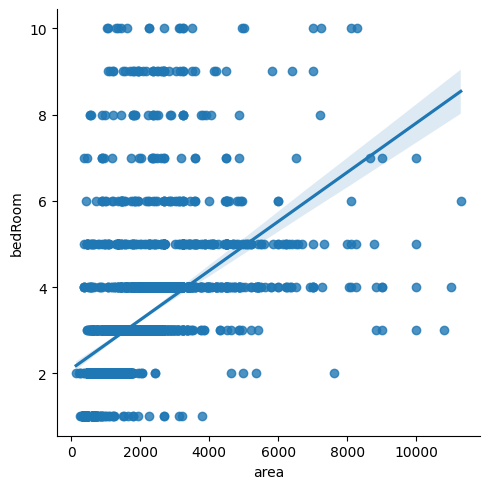

In [60]:
sns.lmplot(data=df, x='area', y='bedRoom')

In [61]:
df['area_room_ratio'] = df['area'] / df['bedRoom']

In [62]:
(df[df['area_room_ratio'] < 250])['bedRoom'].value_counts()

bedRoom
2     47
3     33
5     28
6     17
4     17
9     16
8     12
10     8
7      8
Name: count, dtype: int64

In [63]:
df = df[df['area_room_ratio'] >100]

In [64]:
outlier_df = df[(df['area_room_ratio'] < 250) & (df['bedRoom'] > 3)]

In [65]:
# assuming large bedroom number due to multiple floors in same building so we are calculating average bedroom count per floor
outlier_df['bedRoom'] = round(outlier_df['bedRoom'] / outlier_df['floorNum'])

C:\Users\wasia\AppData\Local\Temp\ipykernel_14976\3579919789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_df['bedRoom'] = round(outlier_df['bedRoom'] / outlier_df['floorNum'])


In [66]:
df.update(outlier_df)

C:\Users\wasia\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)
C:\Users\wasia\AppData\Local\Temp\ipykernel_14976\1617301329.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3. 3. 4. ... 3. 6. 3.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(outlier_df)


In [67]:
# still there are some outliers becuase floorNum is 1 
df[(df['area_room_ratio'] < 250) & (df['bedRoom'] > 4)].sample(5)   

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
90,house,independent,sector 4,0.65,11111.0,585.0,Plot area 65(54.35 sq.m.),inf,2,2,0,NA,Moderately Old,NaN,585.0,NaN,0,0,0,0,0,0,0,146.250000
817,house,independent,sector 12,0.65,6500.0,1000.0,Carpet area: 1000 (92.9 sq.m.),6.0,2,3,1,NA,Undefined,NaN,NaN,1000.0,0,0,0,0,0,0,0,166.666667
1898,house,independent,sector 7,1.16,11717.0,990.0,Carpet area: 110 (91.97 sq.m.),5.0,4,2,1,North-East,Undefined,NaN,NaN,110.0,0,0,0,0,0,0,0,198.000000
2284,house,independent,sector 105,1.10,12222.0,900.0,Carpet area: 900 (83.61 sq.m.),6.0,4,1,1,South-West,Undefined,NaN,NaN,900.0,0,0,0,0,0,0,0,150.000000
1989,house,independent,sector 17,0.32,5664.0,565.0,Built Up area: 565 (52.49 sq.m.),5.0,1,0,1,NA,Undefined,NaN,565.0,NaN,0,0,0,0,0,0,0,113.000000


In [68]:
df[(df['area_room_ratio'] < 250) & (df['bedRoom'] > 4)].shape

(14, 24)

In [69]:
df.shape

(3567, 24)

In [72]:
# removing outliers based on area_room_ratio and bedRoom
df = df[~((df['area_room_ratio'] < 250) & (df['bedRoom'] > 4))]

In [73]:
df.shape

(3553, 24)

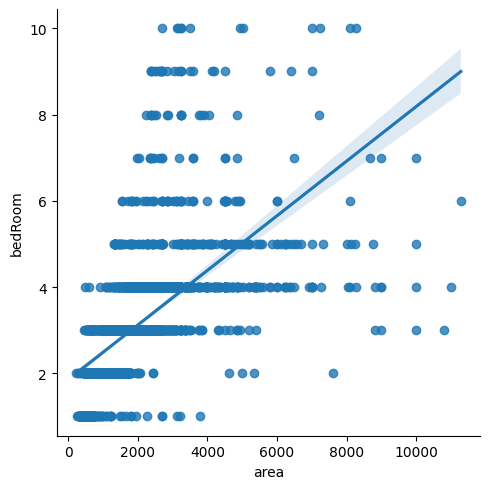

In [74]:
sns.lmplot(x='area', y='bedRoom', data=df)

In [75]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
0,house,independent,sector 4,0.67,8557.0,783.0,Plot area 87(72.74 sq.m.),3.0,2,1,1,South,Moderately Old,NaN,783.0,NaN,0,0,0,1,1,0,19,261.000000
1,flat,zara aavaas,sector 104,0.65,8519.0,763.0,Carpet area: 763 (70.89 sq.m.),3.0,2,2,7,NA,New Property,NaN,NaN,763.0,0,0,0,0,0,0,65,254.333333
2,house,DLF New Town Heights 24.0 ?,sector 86,2.47,7719.0,3200.0,Plot area 3200(297.29 sq.m.)Built Up area: 280...,4.0,4,3+,0,West,Moderately Old,NaN,2800.0,2200.0,0,1,0,1,0,2,130,800.000000
3,flat,shree vardhman victoria,sector 70,1.65,8462.0,1950.0,Super Built up area 1950(181.16 sq.m.)Carpet a...,3.0,4,3,5,South-East,Relatively New,1950.0,NaN,1161.0,0,1,0,0,1,2,49,650.000000
4,flat,central park resort belgravia residences,sector 48,6.25,24300.0,2572.0,Carpet area: 2880 (267.56 sq.m.),3.0,5,3+,5,South-East,Moderately Old,NaN,NaN,2880.0,0,1,0,0,0,2,49,857.333333


In [76]:
df.shape

(3553, 24)

In [77]:
df.to_sql("gurgaon_properties_outlier_treated_v2", con=mysql_engine, if_exists='replace', index=False)

3553

In [80]:
df.to_sql("gurgaon_properties_outlier_treated_v2", con=mssql_engine, if_exists='replace', index=False)

73

In [81]:
df.to_excel("gurgaon_properties_outlier_treated_v2.xlsx", index=False)